<a href="https://colab.research.google.com/github/oliverwsd/Deep-Portfolio/blob/master/LTSM_stock_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from keras.layers import Input, Dense, Dropout,LSTM,BatchNormalization
from keras.models import Model
from keras.models import Sequential
from keras import regularizers
from keras.constraints import maxnorm
from keras.models import load_model
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

matplotlib.rcParams[ 'figure.figsize' ] = ( 20, 6 )


#packages for modelling
import tensorflow.compat.v1 as tfo
import tensorflow as tf
import random as rd
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal

#packages for plotting
%matplotlib inline
import matplotlib.dates as md
import pydot

#packages for extraction and saving data
import os
import glob as glob
import csv

#packages for date handling
import datetime
from time import time

In [56]:
# preparing data for LSTMs
# we consider an embedding layer instead of feeding the entire seires into the model at once
# therefore we split data into smaller peices in an constant window to create a smaller seires of observertion for prediction

def normalize_data(X, Y, LOOKBACK_WINDOW):
    
    _Xs = []
    _Ys = []
    for i in range(len(X) - LOOKBACK_WINDOW):
        cur_X = X[i:i + LOOKBACK_WINDOW]
        _Xs.append(cur_X)
        
        y_pointer = i + LOOKBACK_WINDOW
        cur_Y = Y[y_pointer]
        _Ys.append(cur_Y)
    return np.array(_Xs), np.array(_Ys)

In [48]:
from io import StringIO
import csv
# realized variance 
x_data = 'https://raw.githubusercontent.com/oliverwsd/Deep-Portfolio/master/sp500_selected_15_stock_index.csv'
y_data = 'https://raw.githubusercontent.com/oliverwsd/Deep-Portfolio/master/sp500_index_rv.csv'
# read csv
input_data = pd.read_csv(x_data,index_col=0)
target_data = pd.read_csv(y_data, index_col=0)

In [67]:
# preparation of time-series data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
input_data = sc.fit_transform(input_data)
target_data = sc.fit_transform(target_data)

# x: volatilities of selected 50 stocks and market volatility in the past days
# y: market volatility in the future 
x, y = normalize_data(input_data, target_data, 50)

# Split the data into a training and test set
# We are using 80 percent of the data as training set and 20% as the test set. 
train_size  = int(len(x) * 0.80)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [85]:
model = Sequential()
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(LSTM(units= 50, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
# model.add(LSTM(units=64, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units= 100))
model.add(Dropout(0.2))
# model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units=1, activation='linear'))
# optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer = 'rmsprop', loss = 'mse')
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 50, 50)            13400     
_________________________________________________________________
dropout_24 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 73,901
Trainable params: 73,901
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.fit(x_train, y_train, epochs = 500, batch_size = 32, validation_split=0.05, verbose=1)

Epoch 1/500
26/26 [==============================] - 2s 62ms/step - loss: 9.7688e-05 - val_loss: 2.3142e-05
Epoch 2/500
26/26 [==============================] - 2s 61ms/step - loss: 9.8877e-05 - val_loss: 2.4730e-05
Epoch 3/500
26/26 [==============================] - 2s 60ms/step - loss: 9.8276e-05 - val_loss: 1.4067e-04
Epoch 4/500
26/26 [==============================] - 2s 62ms/step - loss: 1.0057e-04 - val_loss: 2.6073e-05
Epoch 5/500
26/26 [==============================] - 2s 61ms/step - loss: 9.6522e-05 - val_loss: 2.5115e-05
Epoch 6/500
26/26 [==============================] - 2s 62ms/step - loss: 9.7725e-05 - val_loss: 2.8467e-05
Epoch 7/500
26/26 [==============================] - 2s 66ms/step - loss: 9.7538e-05 - val_loss: 2.5993e-05
Epoch 8/500
26/26 [==============================] - 2s 65ms/step - loss: 9.7412e-05 - val_loss: 1.0086e-04
Epoch 9/500
26/26 [==============================] - 2s 63ms/step - loss: 9.6945e-05 - val_loss: 2.4210e-05
Epoch 10/500
26/26 [========

In [93]:
model.evaluate(x_test, y_test, verbose=1)

7/7 [==============================] - 0s 15ms/step - loss: 0.0242


0.02417641319334507

In [94]:
model.save('ltsm_15_stock_index.h5')

In [95]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

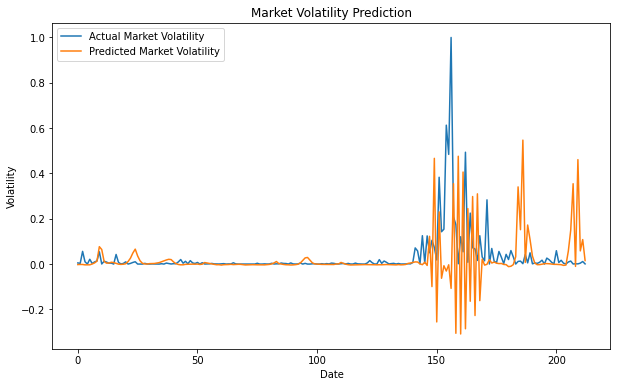

In [100]:
plt.figure(figsize=(10,6))
plt.plot(y_test[:], label='Actual Market Volatility')
plt.plot(predictions[:], label='Predicted Market Volatility')
plt.title('Market Volatility Prediction')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()